# Proyek Klasifikasi Teks: Deteksi Depresi dari Postingan Reddit  

**Author:** Putrawin Adha Muzakki  

## Dataset

- **Sumber:** https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned
- **Fitur (Feature):** `clean_text` - Postingan Reddit yang sudah melalui beberapa tahap pembersihan awal.
- **Target (Label):** `is_depression` - Label biner (1 untuk depresi, 0 untuk non-depresi).

1.  **Setup Lingkungan:**
    - Menghubungkan Google Colab dengan Google Drive untuk akses file.
    - Mengimpor semua library yang dibutuhkan.

In [2]:
# Menghubungkan Google Colab ke Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import library fundamental
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download resource NLTK yang dibutuhkan
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


# Import library dari Scikit-Learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Atur style visualisasi
sns.set_style('whitegrid')

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


2.  **Eksplorasi Data (EDA):** Memuat data, memeriksa distribusi kelas, dan menganalisis panjang teks.

Ukuran dataset: (7731, 2)

Contoh data:


,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1



Jumlah missing values:
clean_text       0
is_depression    0
dtype: int64


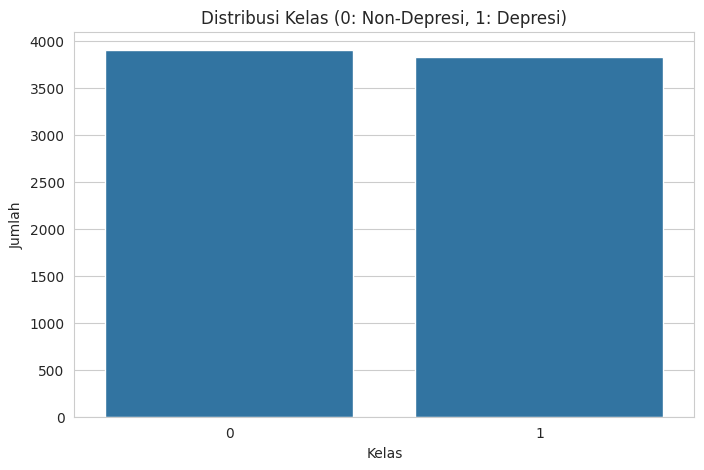


Jumlah masing-masing kelas:
is_depression
0    3900
1    3831
Name: count, dtype: int64


In [3]:
# Tentukan path file di Google Drive
file_path = '/content/drive/MyDrive/Studi_Independen/Tugas 2 Modul 4/depression_dataset_reddit_cleaned.csv'

# Muat data
df = pd.read_csv(file_path)
print("Ukuran dataset:", df.shape)

# Tampilkan beberapa baris pertama
print("\nContoh data:")
display(df.head())

# Periksa missing values
print("\nJumlah missing values:")
print(df.isnull().sum())

# Analisis distribusi kelas target
plt.figure(figsize=(8, 5))
sns.countplot(x='is_depression', data=df)
plt.title('Distribusi Kelas (0: Non-Depresi, 1: Depresi)')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.show()

print("\nJumlah masing-masing kelas:")
print(df['is_depression'].value_counts())

3.  **Text Preprocessing:** Membersihkan teks lebih lanjut dengan menghapus stopwords.

In [4]:
# Inisialisasi Lemmatizer dan Stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. Hapus karakter non-alfabet dan ubah ke huruf kecil
    text = re.sub('[^a-zA-Z]', ' ', text).lower()

    # 2. Tokenisasi (memecah teks menjadi kata-kata)
    words = text.split()

    # 3. Hapus stopwords dan lakukan lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # 4. Gabungkan kembali menjadi satu string
    return ' '.join(words)

# Terapkan fungsi preprocessing ke kolom 'clean_text'
print("Memulai preprocessing teks...")
df['processed_text'] = df['clean_text'].apply(preprocess_text)
print("Preprocessing selesai.")

# Tampilkan perbandingan sebelum dan sesudah
print("\nContoh Teks Sebelum Preprocessing:")
print(df['clean_text'].iloc[2])
print("\nContoh Teks Sesudah Preprocessing:")
print(df['processed_text'].iloc[2])

Memulai preprocessing teks...
Preprocessing selesai.

Contoh Teks Sebelum Preprocessing:
anyone else instead of sleeping more when depressed stay up all night to avoid the next day from coming sooner may be the social anxiety in me but life is so much more peaceful when everyone else is asleep and not expecting thing of you

Contoh Teks Sesudah Preprocessing:
anyone else instead sleeping depressed stay night avoid next day coming sooner may social anxiety life much peaceful everyone else asleep expecting thing


4.  **Feature Engineering:** Teks yang sudah bersih diubah menjadi representasi numerik menggunakan **TF-IDF Vectorizer** dengan `max_features=5000` dan `ngram_range=(1,2)`.
5.  **Pemisahan Data:** Dataset dibagi menjadi 80% data training dan 20% data testing.

In [5]:
# Pisahkan fitur (X) dan target (y)
X = df['processed_text']
y = df['is_depression']

# Bagi data menjadi data training (80%) dan data testing (20%)
# Stratify=y memastikan proporsi kelas di train dan test set sama
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Inisialisasi TF-IDF Vectorizer
# max_features=5000 berarti kita hanya akan menggunakan 5000 kata paling penting
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit vectorizer HANYA pada data training dan transform
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform data testing menggunakan vectorizer yang sudah di-fit
X_test_tfidf = tfidf.transform(X_test)

print(f"Bentuk matriks TF-IDF untuk data training: {X_train_tfidf.shape}")
print(f"Bentuk matriks TF-IDF untuk data testing: {X_test_tfidf.shape}")

Bentuk matriks TF-IDF untuk data training: (6184, 5000)
Bentuk matriks TF-IDF untuk data testing: (1547, 5000)


5.  **Pemodelan:** Tiga model klasifikasi dilatih dan dievaluasi:
    - Multinomial Naive Bayes
    - Logistic Regression
    - Random Forest Classifier

--- Melatih dan Mengevaluasi: Multinomial Naive Bayes ---
Accuracy: 0.9024

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.85      0.90       780
           1       0.86      0.96      0.91       767

    accuracy                           0.90      1547
   macro avg       0.91      0.90      0.90      1547
weighted avg       0.91      0.90      0.90      1547



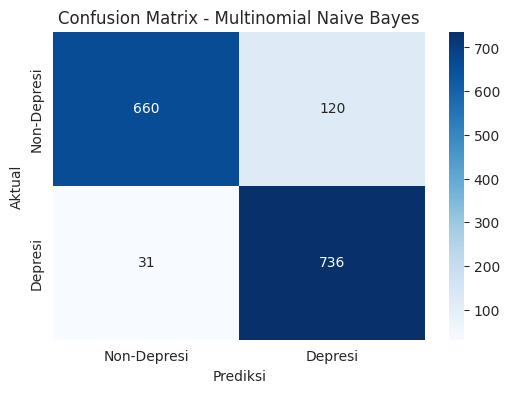



--- Melatih dan Mengevaluasi: Logistic Regression ---
Accuracy: 0.9586

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       780
           1       0.98      0.94      0.96       767

    accuracy                           0.96      1547
   macro avg       0.96      0.96      0.96      1547
weighted avg       0.96      0.96      0.96      1547



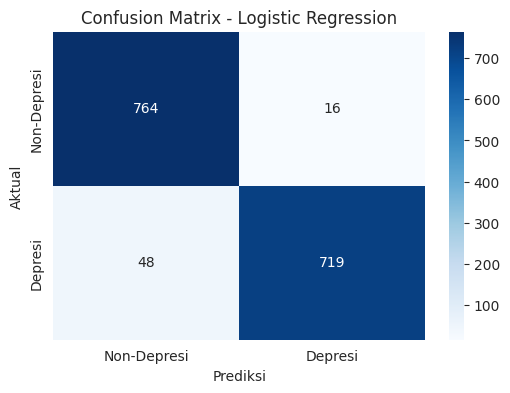



--- Melatih dan Mengevaluasi: Random Forest ---
Accuracy: 0.9612

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       780
           1       0.99      0.93      0.96       767

    accuracy                           0.96      1547
   macro avg       0.96      0.96      0.96      1547
weighted avg       0.96      0.96      0.96      1547



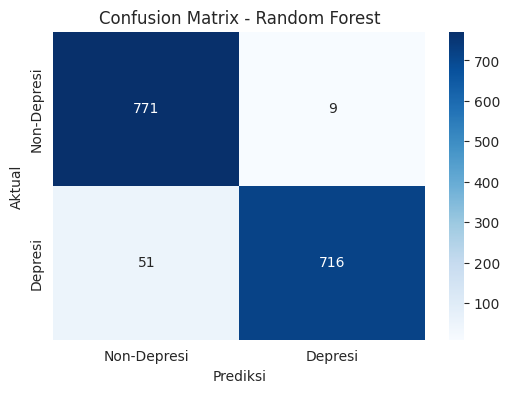

In [6]:
def evaluate_model(model, model_name):
    """Fungsi untuk melatih, memprediksi, dan mengevaluasi model."""
    print(f"--- Melatih dan Mengevaluasi: {model_name} ---")

    # Latih model
    model.fit(X_train_tfidf, y_train)

    # Buat prediksi
    y_pred = model.predict(X_test_tfidf)

    # Evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}\n")
    print("Classification Report:\n", report)

    # Visualisasi Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Depresi', 'Depresi'], yticklabels=['Non-Depresi', 'Depresi'])
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    print("\n" + "="*50 + "\n")

# Inisialisasi model-model yang akan digunakan
models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Latih dan evaluasi setiap model
for name, model in models.items():
    evaluate_model(model, name)

## Hasil & Pembahasan

Berdasarkan evaluasi pada data testing, berikut adalah ringkasan performa dari ketiga model:

| Model | Accuracy | Recall (Kelas 1) | Precision (Kelas 1) | False Negatives (FN) |
| :--- | :---: | :---: | :---: | :---: |
| **Multinomial Naive Bayes** | **~90.2%** | **~96.0%** | ~86.0% | **31** |
| Logistic Regression | ~95.9% | ~93.7% | ~97.8% | 48 |
| Random Forest Classifier | ~96.1% | ~93.3% | **~98.8%** | 51 |

### Analisis Individual Model:

*   **Multinomial Naive Bayes:**
    Model ini menunjukkan **Recall tertinggi** untuk kelas depresi (96%). Artinya, ia sangat efektif dalam mengidentifikasi sebagian besar postingan yang memang mengindikasikan depresi, dengan hanya melewatkan 31 kasus. Namun, kelemahannya adalah Precision yang lebih rendah, yang terlihat dari 120 False Positives (salah memprediksi non-depresi sebagai depresi). Model ini bersifat sangat sensitif.

*   **Logistic Regression:**
    Model ini memberikan keseimbangan yang sangat baik antara Precision dan Recall. Dengan akurasi keseluruhan 95.9% dan Precision yang sangat tinggi untuk kelas depresi (97.8%), prediksi positifnya sangat dapat diandalkan. Namun, ia melewatkan 48 kasus depresi, lebih banyak dari Naive Bayes.

*   **Random Forest Classifier:**
    Model ini memiliki **Precision tertinggi** (98.8%), artinya jika ia memprediksi sebuah teks sebagai "depresi", hampir pasti prediksinya benar. Ini ditunjukkan dengan hanya 9 False Positives. Namun, ini dicapai dengan mengorbankan Recall, karena model ini memiliki **False Negatives tertinggi** (melewatkan 51 kasus depresi).